### Import Libraries

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mpl

### Weighting Function

In [58]:
def get_weights(d, size):
    # threshold > 0 drops insignificant weights
    w=[1.0]
    for k in range(1, size):
        w_=w[-1]/k*(d-k+1)
        w.append(w_)
    w=np.array(w[::-1]).reshape(-1,1)
    return w

In [69]:
def plot_weights(d_range, n_plots, size):
    w=pd.DataFrame()
    for d in np.linspace(d_range[0], d_range[1], n_plots):
        d = round(d, 2) # cut off floating point errors
        w_ = get_weights(d, size=size)
        w_ = pd.DataFrame(w_, index=range(w_.shape[0])[::-1], columns=[d])
        w = w.join(w_, how='outer')
        
    ax=w.plot(figsize=(12, 8))
    ax.legend(loc='upper right'); mpl.show()
    return

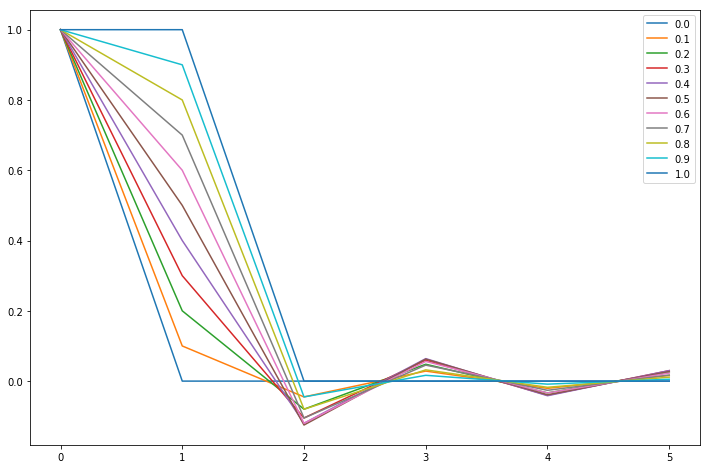

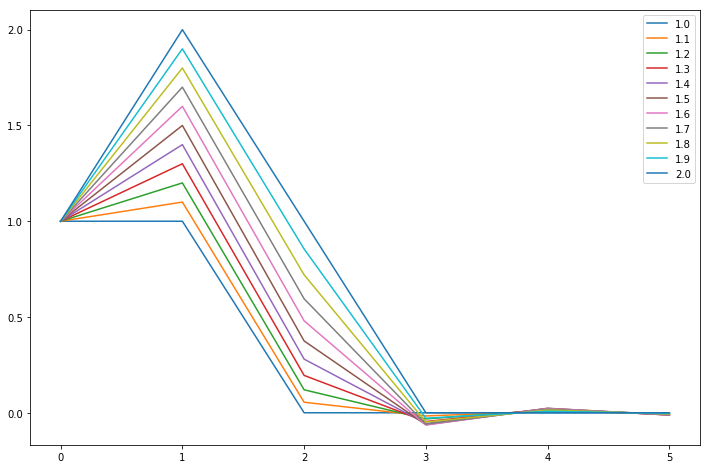

In [70]:
plot_weights([0,1], 11, 6)
plot_weights([1,2], 11, 6)

### Standard Frac Diff (Expanding Window)

In [72]:
def frac_diff(series, d, threshold=0.01):
    """
    Increasing width window, with treatment of NaNs
        - threshold=1 nothing is skipped
        - d can be any positive fractional, not necessarily bounded [0.1]
    """
    
    # compute weights for the logest series
    w = get_weights(d, series.shape[0])
    # determine initial clacs to be skipped based on weight-loss threshold
    w_ = np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_ > threshold].shape[0]
    # apply weights to values
    df = {}
    for name in series.columns:
        series_f, df_ = series[[name]].fillna(methods='ffill').dropna(), pd.Series()
        for iloc in range(skip, series_f.shape[0]):
            loc = series_f.index[iloc]
            if not np.isfinite(series.loc[loc, name]): continue # exclued NAs
            df_[loc] = np.dot(w[-(iloc+1):,:].T, series_f.loc[:loc])[0,0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

### Fixed Width Window Frac Diff

In [74]:
def get_weights_ffd(d, threshold):
    # TODO - Implement function
    pass
    

In [75]:
def frac_dff_ffd(series, d, threshold=1e-5):
    """
    Constant width window (new solution)
        - threshold determines the cut-off weight for the window
        - d can be any positive fractional, not necessarily bounded [0,1]
    """

    # compute weights for the longest series
    w = get_weights_ffd(d, threshold)
    width = len(w) - 1
    # apply weights to values
    df = {}
    for name in series.columns:
        series_f, df_ = series[[name]].fillna(methods='ffill').dropna(), pd.Series()
        for iloc1 in range(width, series_f.shape[0]):
            loc0, loc1 = series_f.index[iloc1-width], series_f.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]): continue # exclued NAs
            df_[loc1] = np.dot(w.T, series_f.loc[loc0:loc1])[0,0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df